# Moving barrier constraint figure

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth

In [2]:
def generate_dynamic_maze(T, H, W, scale_x, scale_y, amp_x, amp_y, scale_t, offset):
    maze = np.zeros((T, H, W), dtype=np.int8)
    import math
    for t in range(T):
        for x in range(H):
            for y in range(W):
                val = (amp_x * math.sin(math.pi * (x/scale_x + t/scale_t)) + amp_y * math.cos(math.pi * (y/scale_y - t/scale_t))) + offset
                maze[t,x,y] = 1 if val>0 else 0
    maze[:,0:5,0:5] = 0
    maze[:,H-5:H,W-5:W] = 0
    return maze

In [3]:
T, N1, N2 = 20, 30, 30
scale_x, scale_y, amp_x, amp_y, scale_t, offset = 5.0,5.0,1.0,2.0,5.0,0.15
maze = generate_dynamic_maze(T,N1,N2,scale_x,scale_y,amp_x,amp_y,scale_t,offset)
H = maze.astype(np.float32)
F = np.zeros((T,))
indices = np.arange(0,N1)*1./N1
xx, yy = np.meshgrid(indices, indices)
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx,yy],axis=-1),mean=[2./N1,2./N2],cov=1./(N1)**2)
rho_0[H[0]>0] = 0
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx,yy],axis=-1),mean=[(N2-3)/N2,(N2-3)/N2],cov=1./(N1)**2)
rho_1[H[0]>0] = 0

In [4]:
ll = (1.0,1.0,1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p=2.0, q=2.0, delta=10.0, niter=1000, big_matrix=True, verbose=False, init="fisher-rao")

/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


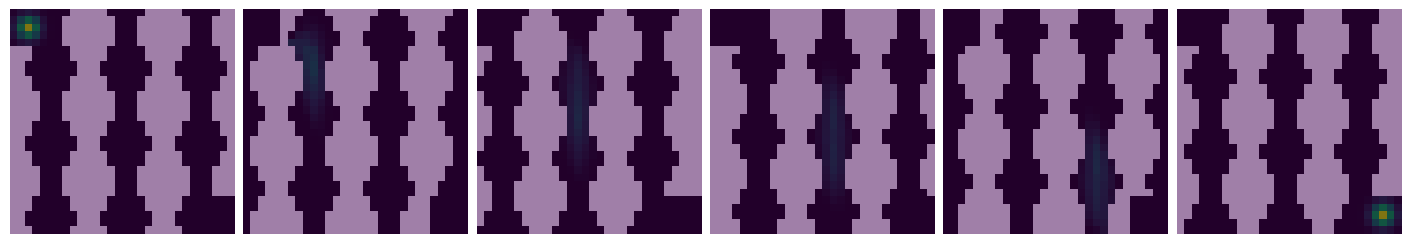

In [5]:
snap_fracs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
idx = [int(round(f*(T-1))) for f in snap_fracs]
densities = []
for k in idx:
    if k==0:
        densities.append(rho_0)
    elif k==T-1:
        densities.append(rho_1)
    else:
        densities.append(x.V.D[0][k])
obstacles = [(H[k]>0) for k in idx]
vmin = min(d.min() for d in densities)
vmax = max(d.max() for d in densities)
fig, axes = plt.subplots(1, len(idx), figsize=(14,3), constrained_layout=True)
for ax, dens, obs in zip(axes, densities, obstacles):
    ax.imshow(dens, cmap="viridis", vmin=vmin, vmax=vmax, origin="upper")
    ax.imshow(obs, cmap="Greys_r", alpha=0.5, origin="upper")
    ax.axis("off")
fig.savefig("figures/moving_barrier_density_snapshots.png", dpi=300, bbox_inches="tight")
plt.show()